In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

/home/qazw5741/miniconda3/envs/SAM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:
from pycocotools.coco import COCO
import os.path as osp
db = COCO(osp.join('/database/changhee/3dpw/','data', '3DPW_latest_' + 'train' + '.json'))

loading annotations into memory...
Done (t=3.80s)
creating index...
index created!


In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/qazw5741/segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [17]:
import cv2
import numpy as np
path_img="/database/changhee/3dpw/imageFiles"
for sub_n,iid in enumerate(db.imgs.keys()):
    if sub_n!=20000:
        continue
    aids = db.getAnnIds([iid])
    img = db.imgs[iid]
    imgname = img['file_name']
    sequence_name = img['sequence']
    image=cv2.imread(osp.join(path_img,sequence_name,imgname))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    joints=[]
    for aid in aids:
        ann = db.anns[aid]
        joint_img = np.array(ann['joint_img'], dtype=np.float32).reshape(-1, 2)
        joints.append(joint_img)
    break

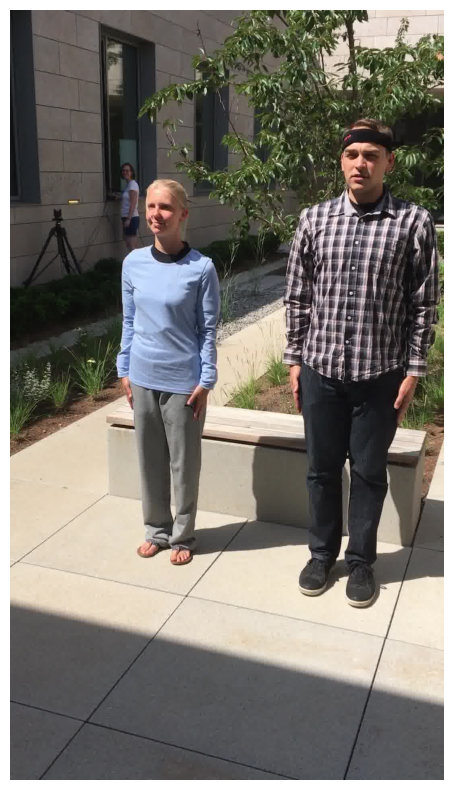

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.savefig("./assets/3dpw_input.jpg",bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
predictor.set_image(image)

In [7]:
j_valid=np.ones((24,1))
new_j=np.concatenate((joints[0],j_valid),axis=1)

In [8]:
input_point = new_j[:,:2]
input_label = new_j[:,2]

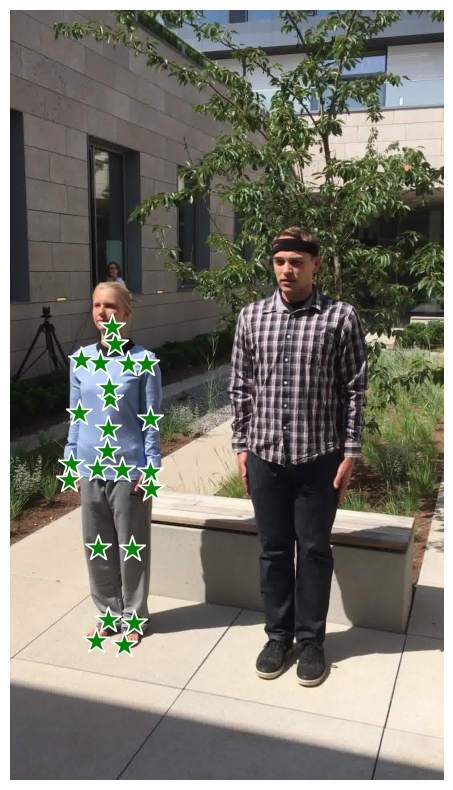

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.savefig("./assets/3dpw_2d_input.jpg",bbox_inches='tight', pad_inches=0)
plt.show()  

In [12]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

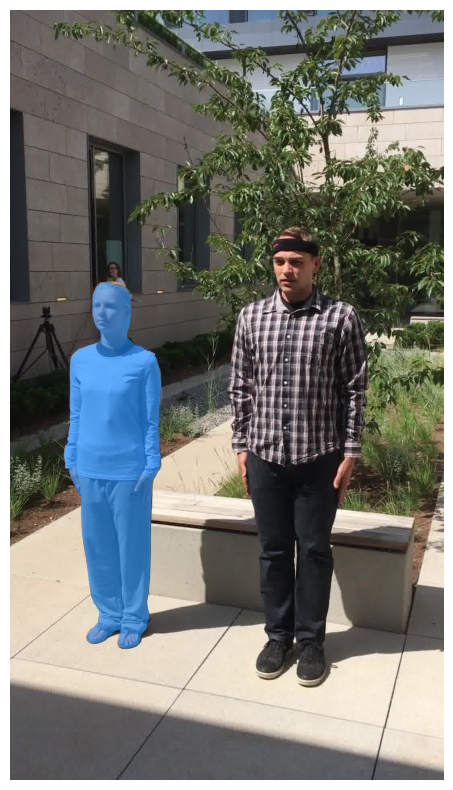

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[2], plt.gca())
plt.axis('off')
plt.savefig("./assets/3dpw_mask.jpg",bbox_inches='tight', pad_inches=0)
plt.show() 